# Will I want you to be my date?

Predicting whether a person will want to go out on a date with a potential romantic partner they have just met.

### Notebook Key:
* Variables ending in _p: partner's variables
* Variables ending in _d: difference between person and partner (for numerical variables)
* Variables ending in _s: Indicator variable for match between person and partner (for categorical variables)


## Loading the Dataset

In [1]:
# installing necessary packages
!pip install xgboost==1.7.1
!pip install statsmodels==0.13.5
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 12.3 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 136.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 KB 48.3 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 10.7 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install missingno==0.5.1

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
# importing modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import missingno as msno
import graphviz
from sklearn.model_selection  import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from pandas.core.common import SettingWithCopyWarning
from IPython.display import display_svg

In [4]:
# Loading Data
df = pd.read_csv("Speed Dating Data.csv", encoding='ISO-8859-1')
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 195 entries, iid to amb5_3
dtypes: float64(174), int64(13), object(8)
memory usage: 12.5+ MB


## Data Cleaning

Although we were interested in including a proxy for wealth in our predictions, we were unable to include the income variable. The researchers calculated income using zip code as a proxy, but there are around 50% missing values for income as not all participants were US residents or reported their American zip code.


In [6]:
df['income'].isnull().mean()

0.4892575793745524

Features we will use in our analysis:

In [7]:
ids = ['iid', 'pid']
personal = ['gender', 'age', 'field_cd', 'race', 'imprace', 'imprelig', 'goal', 'date', 'go_out']
interests_match = ['sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming',  
                    'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']
decision = ['dec', 'like', 'prob' , 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar']       
importance_rate = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

In [8]:
# create dataframe with features needed
features = ids + personal + interests_match + decision + importance_rate
df = df[features]
len(features)

43

#### Modifying Column Types

In [9]:
cat_variables = ["gender", "field_cd", "race", "goal", "date", "go_out"] # only features

for c in cat_variables: 
    df[c] = df[c].astype("category")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 43 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   iid       8378 non-null   int64   
 1   pid       8368 non-null   float64 
 2   gender    8378 non-null   category
 3   age       8283 non-null   float64 
 4   field_cd  8296 non-null   category
 5   race      8315 non-null   category
 6   imprace   8299 non-null   float64 
 7   imprelig  8299 non-null   float64 
 8   goal      8299 non-null   category
 9   date      8281 non-null   category
 10  go_out    8299 non-null   category
 11  sports    8299 non-null   float64 
 12  tvsports  8299 non-null   float64 
 13  exercise  8299 non-null   float64 
 14  dining    8299 non-null   float64 
 15  museums   8299 non-null   float64 
 16  art       8299 non-null   float64 
 17  hiking    8299 non-null   float64 
 18  gaming    8299 non-null   float64 
 19  clubbing  8299 non-null   float64 
 20  reading 

<AxesSubplot: >

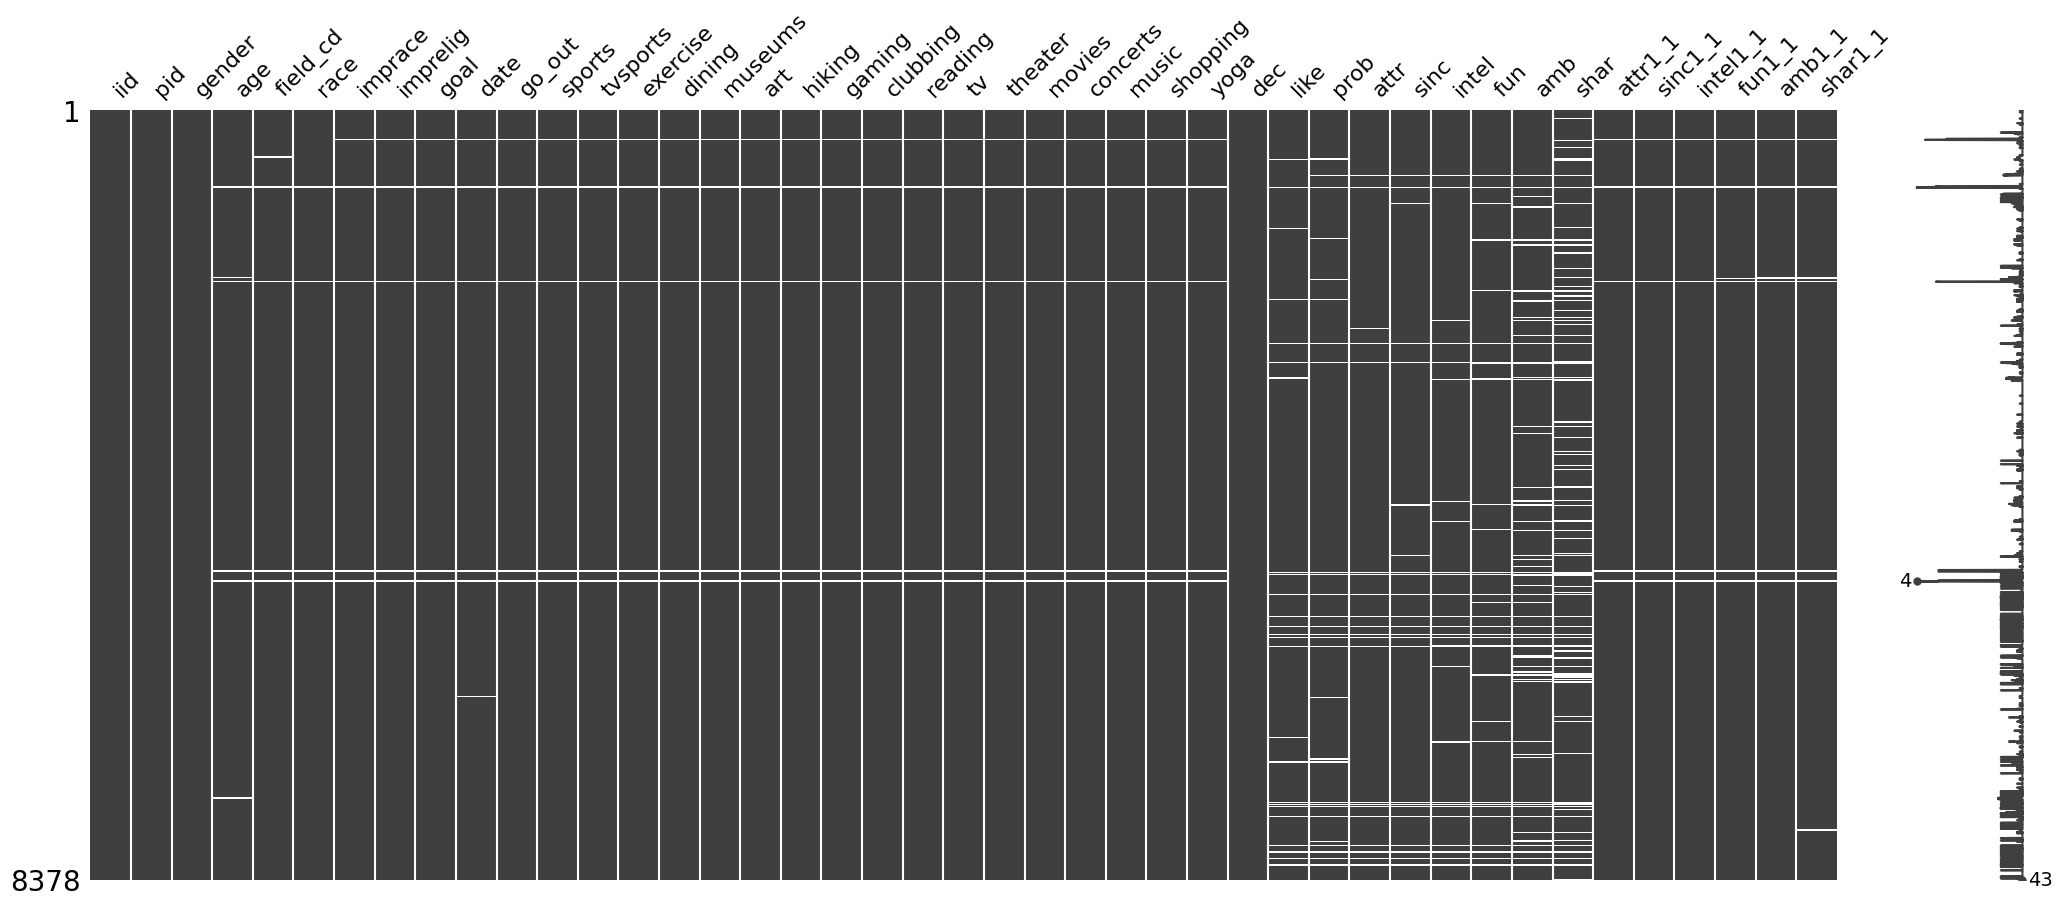

In [10]:
# missing variables
msno.matrix(df)

#### Handling Data Anomalies and Missing Values

In [11]:
# finding missing values
columns = df.columns
null_vars_df = {}

for col in columns:
    current_col = df[col]
    null_count = current_col.isnull().sum()
    if null_count > 0:
        null_vars_df[col] = null_count

len(null_vars_df)

40

In [12]:
# "personal columns": columns that are the same across all rows of a person
df_personal = df[["iid"] + personal + interests_match + importance_rate].drop_duplicates()
df_personal = df_personal.set_index("iid")
print(df_personal.columns)

Index(['gender', 'age', 'field_cd', 'race', 'imprace', 'imprelig', 'goal',
       'date', 'go_out', 'sports', 'tvsports', 'exercise', 'dining', 'museums',
       'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater',
       'movies', 'concerts', 'music', 'shopping', 'yoga', 'attr1_1', 'sinc1_1',
       'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1'],
      dtype='object')


In [13]:
# importance rate features should add up to 100

# observations for 9 participants don't add up to 100
# (there are also rounding errors but those are okay)
df_personal[abs(df_personal[importance_rate].sum(axis=1) - 100) > 1].dropna()

df_personal[importance_rate].loc[[44]].sum(axis=1) # adds up to 120
df_personal[importance_rate].loc[[66]].sum(axis=1) # adds up to 148
df_personal[importance_rate].loc[[67]].sum(axis=1) # adds up to 90
df_personal[importance_rate].loc[[105]].sum(axis=1) # adds up to 90

# rescale everything so all importance_rate features add up to 100 for all participants
df_personal["sum"] = df_personal["attr1_1"] + df_personal["sinc1_1"] +\
    df_personal["intel1_1"] + df_personal["fun1_1"] + df_personal["amb1_1"] + df_personal["shar1_1"]
for c in df_personal[importance_rate].columns:
    df_personal[c] = round((df_personal[c] / df_personal["sum"]) * 100, 2)

# remove sum (helper column) from dataframe
df_personal = df_personal[df_personal.columns.difference(["sum"])]

In [14]:
# interests_match columns should go from 1 to 10
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# observations for some participants are < 1 or > 10
df_personal[df_personal["gaming"] > 10]
df_personal[df_personal["reading"] > 10]

# for observations < 1, make them 1
# and for observations > 10, make them 10 
def interest_threshold(x):
    if x < 1: return 1 
    if x > 10: return 10 
    return x 

for c in df_personal[interests_match].columns: 
    df_personal[c] = df_personal[c].apply(interest_threshold)

In [15]:
df_personal[importance_rate]

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1
iid,,,,,,
1,15.0,20.0,20.0,15.0,15.0,15.0
2,45.0,5.0,25.0,20.0,0.0,5.0
3,35.0,10.0,35.0,10.0,10.0,0.0
4,20.0,20.0,20.0,20.0,10.0,10.0
5,20.0,5.0,25.0,25.0,10.0,15.0
...,...,...,...,...,...,...
548,40.0,10.0,20.0,10.0,0.0,20.0
549,20.0,20.0,20.0,20.0,0.0,20.0
550,30.0,3.0,30.0,30.0,3.0,4.0


In [16]:
# impute missing values using KNN 
# for numerical variables
df_personal_imputed = df_personal[df_personal.columns.difference(["sum"] + cat_variables)]

imputer = KNNImputer(missing_values = np.nan, n_neighbors=5)
df_personal_imputed = pd.DataFrame(imputer.fit_transform(df_personal_imputed), 
    columns=df_personal_imputed.columns,
    index=df_personal_imputed.index)

for c in df_personal_imputed.columns: 
    df_personal[c] = df_personal_imputed[c]

In [17]:
# impute missing values using mode 
# for categorical variables 
for c in cat_variables: 
    df_personal[c] = df_personal[c].fillna(df_personal[c].mode()[0])

In [18]:
df_personal = df_personal.reset_index()
df_personal

,iid,age,amb1_1,art,attr1_1,clubbing,concerts,date,dining,exercise,...,race,reading,shar1_1,shopping,sinc1_1,sports,theater,tv,tvsports,yoga
0,1,21.0,15.0,1.0,15.0,5.0,10.0,7.0,9.0,8.0,...,4.0,6.0,15.0,8.0,20.0,9.0,1.0,9.0,2.0,1.0
1,2,24.0,0.0,6.0,45.0,8.0,7.0,5.0,10.0,7.0,...,2.0,10.0,5.0,3.0,5.0,3.0,9.0,1.0,2.0,1.0
2,3,25.0,10.0,5.0,35.0,5.0,7.0,3.0,8.0,7.0,...,2.0,7.0,0.0,8.0,10.0,3.0,7.0,8.0,8.0,7.0
3,4,23.0,10.0,7.0,20.0,7.0,8.0,5.0,7.0,6.0,...,2.0,7.0,10.0,1.0,20.0,1.0,9.0,7.0,1.0,8.0
4,5,21.0,10.0,8.0,20.0,8.0,3.0,4.0,7.0,7.0,...,2.0,6.0,15.0,8.0,5.0,7.0,6.0,8.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,548,30.0,0.0,2.0,40.0,1.0,7.0,6.0,10.0,4.0,...,2.0,9.0,20.0,4.0,10.0,10.0,4.0,6.0,8.0,1.0
547,549,28.0,0.0,7.0,20.0,8.0,10.0,7.0,9.0,6.0,...,2.0,7.0,20.0,8.0,20.0,8.0,8.0,7.0,5.0,2.0
548,550,30.0,3.0,8.0,30.0,8.0,4.0,4.0,9.0,5.0,...,2.0,8.0,4.0,6.0,3.0,5.0,7.0,3.0,3.0,3.0
549,551,27.0,0.0,3.0,40.0,7.0,7.0,6.0,6.0,7.0,...,1.0,10.0,0.0,7.0,20.0,6.0,5.0,2.0,1.0,1.0


In [19]:
# merge imputed values with original dataframe 
df = df.merge(df_personal, how="inner", on="iid", suffixes=("_x", ""))

# remove unnecessary columns (suffixed with _x)
df = df.loc[:,~df.columns.str.endswith("x")]

In [20]:
# partner variables  

# if partner id (pid) is missing, we can't evaluate the experiment
# so we drop 10 missing observations
df = df.dropna(subset = ['pid'])

partner_variables = ["like", "prob", "attr", "sinc", "intel", "fun", "amb", "shar"]

# imput partner variables 
imputer = KNNImputer(missing_values = np.nan, n_neighbors=5)
df[partner_variables] = pd.DataFrame(imputer.fit_transform(df[partner_variables]), 
    columns = df[partner_variables].columns, 
    index = df[partner_variables].index)

In [21]:
# There are no null values anymore!
columns = df.columns
null_vars_df = {}

for col in columns:
    current_col = df[col]
    null_count = current_col.isnull().sum()
    if null_count > 0:
        null_vars_df[col] = null_count

len(null_vars_df)

0

In [22]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551 entries, 0 to 550
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   iid       551 non-null    int64   
 1   age       551 non-null    float64 
 2   amb1_1    551 non-null    float64 
 3   art       551 non-null    float64 
 4   attr1_1   551 non-null    float64 
 5   clubbing  551 non-null    float64 
 6   concerts  551 non-null    float64 
 7   date      551 non-null    category
 8   dining    551 non-null    float64 
 9   exercise  551 non-null    float64 
 10  field_cd  551 non-null    category
 11  fun1_1    551 non-null    float64 
 12  gaming    551 non-null    float64 
 13  gender    551 non-null    category
 14  go_out    551 non-null    category
 15  goal      551 non-null    category
 16  hiking    551 non-null    float64 
 17  imprace   551 non-null    float64 
 18  imprelig  551 non-null    float64 
 19  intel1_1  551 non-null    float64 
 20  movies    

#### Feature Engineering

In [23]:
# merge partner variables into df to calculate interest similarity
df = df.merge(df_personal, left_on="pid", right_on="iid", suffixes=("", "_p"))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8368 entries, 0 to 8367
Data columns (total 76 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   iid         8368 non-null   int64   
 1   pid         8368 non-null   float64 
 2   dec         8368 non-null   int64   
 3   like        8368 non-null   float64 
 4   prob        8368 non-null   float64 
 5   attr        8368 non-null   float64 
 6   sinc        8368 non-null   float64 
 7   intel       8368 non-null   float64 
 8   fun         8368 non-null   float64 
 9   amb         8368 non-null   float64 
 10  shar        8368 non-null   float64 
 11  age         8368 non-null   float64 
 12  amb1_1      8368 non-null   float64 
 13  art         8368 non-null   float64 
 14  attr1_1     8368 non-null   float64 
 15  clubbing    8368 non-null   float64 
 16  concerts    8368 non-null   float64 
 17  date        8368 non-null   category
 18  dining      8368 non-null   float64 
 19  exerci

In [24]:
# Consolidate field_cd, race, goal, date, and go_out into more comprehensive categories
dict_field_cd = {1 :1, # Law  
                3 : 1, # Social Science, Psychologist 
                6 : 1, # English/Creative Writing/ Journalism 
                7 : 1, # History/Religion/Philosophy 
                13: 1, # Political Science/International Affairs 
                16: 1, # Languages
                2 : 2, # Math
                5 : 2, # Engineering
                17: 2, # Architecture
                4 : 3, # Medical Science, Pharmaceuticals, and Bio Tech  
                10: 3, # Biological Sciences/Chemistry/Physics
                8 : 4, # Business/Econ/Finance
                14: 5, # Film
                15: 5, # Fine Arts/Arts Administration
                9 : 6, # Education, Academia 
                11: 6, # Social Work 
                12: 6, # Undergrad/undecided 
                18: 6} # Other

dict_goal = {1 : 0,  # Seemed like a fun night out
             2 : 1,  # To meet new people
             3 : 1,  # To get a date
             4 : 1,  # Looking for a serious relationship
             5 : 0,  # To say I did it
             6 : 0}  # Other

dict_date = {1 : 1,  # Several times a week
             2 : 1,  # Twice a week
             3 : 1,  # Once a week
             4 : 0,  # Twice a month
             5 : 0,  # Once a month
             6 : 0,  # Several times a year
             7 : 0}  # Almost never

dict_go_out = {1 : 1,  # Several times a week
             2 : 1,  # Twice a week
             3 : 1,  # Once a week
             4 : 0,  # Twice a month
             5 : 0,  # Once a month
             6 : 0,  # Several times a year
             7 : 0} # Almost never

df.replace({"field_cd": dict_field_cd,
    "date": dict_date, 
    "go_out": dict_go_out,
    "field_cd_p": dict_field_cd, 
    "date_p": dict_date, 
    "go_out_p": dict_go_out},inplace=True)

In [25]:
# Calculate difference between person and potential partner's variables
# for age, imprace, imprelig and interests (numerical)
var_diff = ["age", "imprace", "imprelig"] + interests_match
for var in var_diff: 
    df[f"{var}_d"] = abs(df[var] - df[f"{var}_p"])

# And calculate whether person and potential partner's variables are the same
# for field_cv, race, goal, date and go_out (categorical)
var_same = ["field_cd", "race", "goal", "date", "go_out"]
for var in var_same: 
    df[f"{var}_s"] = (df[var] == df[f"{var}_p"]) * 1

In [27]:
# take only columns we will use
sorted(list(df.columns))

cols = ["age", "age_d", "amb", "amb1_1", "art_d", "attr", "attr1_1", "clubbing_d", "concerts_d",
    "date_s", "dec", "dining_d", "exercise_d", "field_cd", "field_cd_s", "fun", "fun1_1",
    "gaming_d", "gender", "go_out_s", "goal_s", "hiking_d", "iid", "imprace", "imprace_d", 
    "imprelig_d", "intel", "intel1_1", "like", "movies_d", "museums_d", "music_d", "pid", 
    "prob", "race", "race_s", "reading_d", "shar", "shar1_1", "shopping_d", "sinc",
    "sports_d", "theater_d", "tv_d", "tvsports_d", "yoga_d"] 
# "attr_weighted", "sinc_weighted", "intel_weighted", "amb_weighted", "shar_weighted"]

df = df[cols]

## Data Visualization

In [28]:
df_personal

,iid,age,amb1_1,art,attr1_1,clubbing,concerts,date,dining,exercise,...,race,reading,shar1_1,shopping,sinc1_1,sports,theater,tv,tvsports,yoga
0,1,21.0,15.0,1.0,15.0,5.0,10.0,7.0,9.0,8.0,...,4.0,6.0,15.0,8.0,20.0,9.0,1.0,9.0,2.0,1.0
1,2,24.0,0.0,6.0,45.0,8.0,7.0,5.0,10.0,7.0,...,2.0,10.0,5.0,3.0,5.0,3.0,9.0,1.0,2.0,1.0
2,3,25.0,10.0,5.0,35.0,5.0,7.0,3.0,8.0,7.0,...,2.0,7.0,0.0,8.0,10.0,3.0,7.0,8.0,8.0,7.0
3,4,23.0,10.0,7.0,20.0,7.0,8.0,5.0,7.0,6.0,...,2.0,7.0,10.0,1.0,20.0,1.0,9.0,7.0,1.0,8.0
4,5,21.0,10.0,8.0,20.0,8.0,3.0,4.0,7.0,7.0,...,2.0,6.0,15.0,8.0,5.0,7.0,6.0,8.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,548,30.0,0.0,2.0,40.0,1.0,7.0,6.0,10.0,4.0,...,2.0,9.0,20.0,4.0,10.0,10.0,4.0,6.0,8.0,1.0
547,549,28.0,0.0,7.0,20.0,8.0,10.0,7.0,9.0,6.0,...,2.0,7.0,20.0,8.0,20.0,8.0,8.0,7.0,5.0,2.0
548,550,30.0,3.0,8.0,30.0,8.0,4.0,4.0,9.0,5.0,...,2.0,8.0,4.0,6.0,3.0,5.0,7.0,3.0,3.0,3.0
549,551,27.0,0.0,3.0,40.0,7.0,7.0,6.0,6.0,7.0,...,1.0,10.0,0.0,7.0,20.0,6.0,5.0,2.0,1.0,1.0


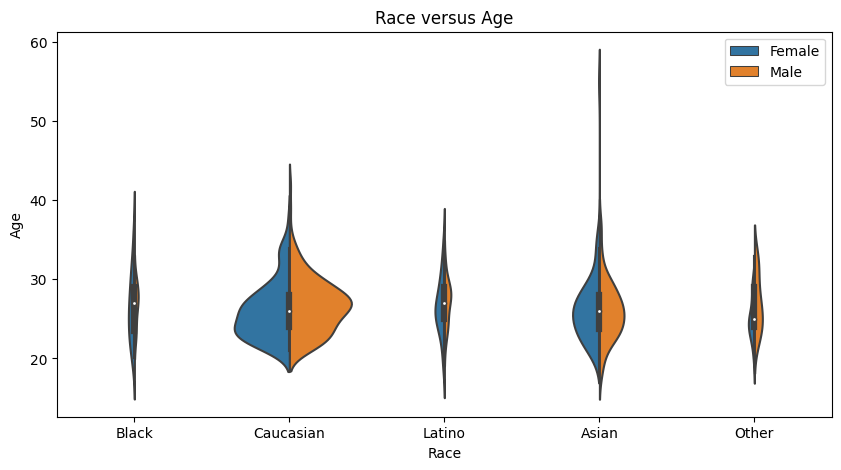

In [29]:
dict_race_label = {1: 'Black', 2: 'Caucasian', 3: 'Latino', 4: 'Asian', 6: 'Other'}
fig, ax = plt.subplots(1,1, figsize=(10,5))

sns.violinplot(data=df_personal, x="race", y="age", hue='gender', split=True, 
    scale_hue=False, scale='count')
ax.set_title("Race versus Age")
ax.set_xlabel("Race")
ax.set_ylabel("Age")
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Female','Male'])
ax.set_xticklabels(dict_race_label.values())
plt.show()

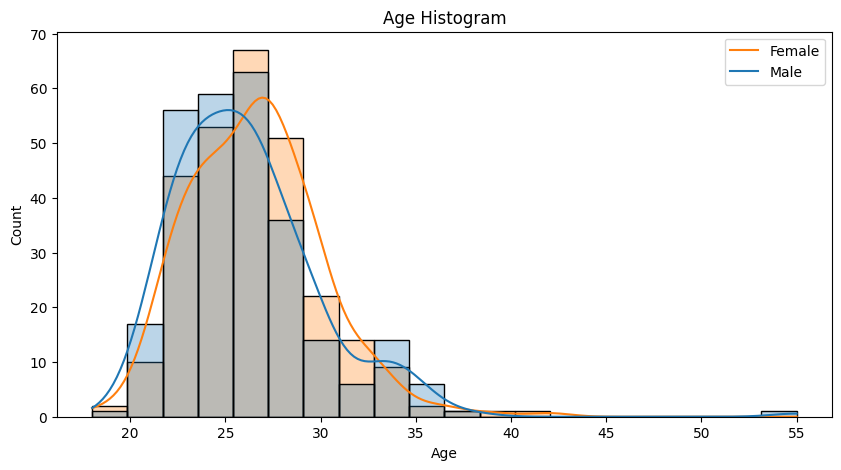

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.histplot(data=df_personal, bins = 20,
            x="age", kde=True, hue="gender", legend=True, alpha=0.3)
ax.set_title("Age Histogram")
ax.set_xlabel("Age")
ax.set_ylabel("Count")
ax.legend(['Female','Male'])
plt.show()

/tmp/ipykernel_214/1166800081.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['Ambition','Shared Interests','Sincerity','Fun','Intelligence', 'Attractiveness','Intelligence'])


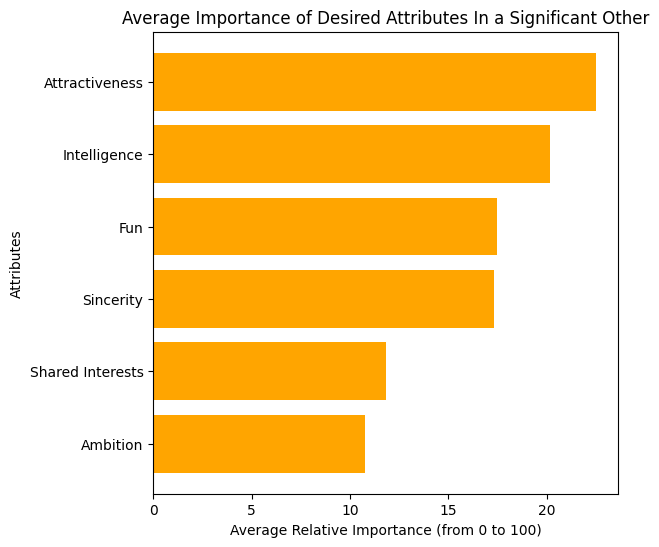

In [31]:
attribute_importance_means = df_personal[importance_rate].mean().sort_values()
fig, ax = plt.subplots(1, 1, figsize = (6, 6)) 
attribute_importance_means.index
ax.barh(attribute_importance_means.index, attribute_importance_means , color='orange')
ax.set_yticklabels(['Ambition','Shared Interests','Sincerity','Fun','Intelligence', 'Attractiveness','Intelligence'])
ax.set_title('Average Importance of Desired Attributes In a Significant Other')
ax.set_ylabel('Attributes')
ax.set_xlabel('Average Relative Importance (from 0 to 100)');

/tmp/ipykernel_214/1110975734.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Intelligence', 'Sincerity', 'Ambition', 'Fun', 'Attractiveness', 'Shared interests'])


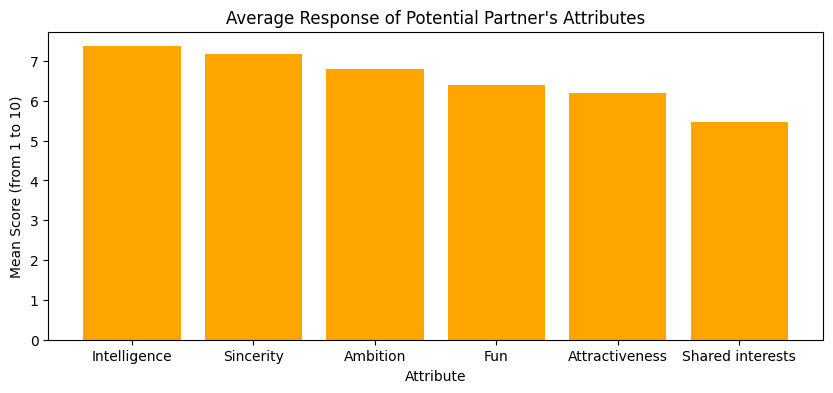

In [32]:
attr_importance_summary = df[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar']].mean().sort_values(ascending=False)
fig, ax = plt.subplots(1, 1, figsize = (10, 4)) 
ax.bar(attr_importance_summary.index, attr_importance_summary, color='orange')
legend_labels, _= ax.get_legend_handles_labels()
ax.set_xticklabels(['Intelligence', 'Sincerity', 'Ambition', 'Fun', 'Attractiveness', 'Shared interests'])
ax.set_title("Average Response of Potential Partner's Attributes")
ax.set_ylabel("Mean Score (from 1 to 10)")
ax.set_xlabel("Attribute")
plt.show()

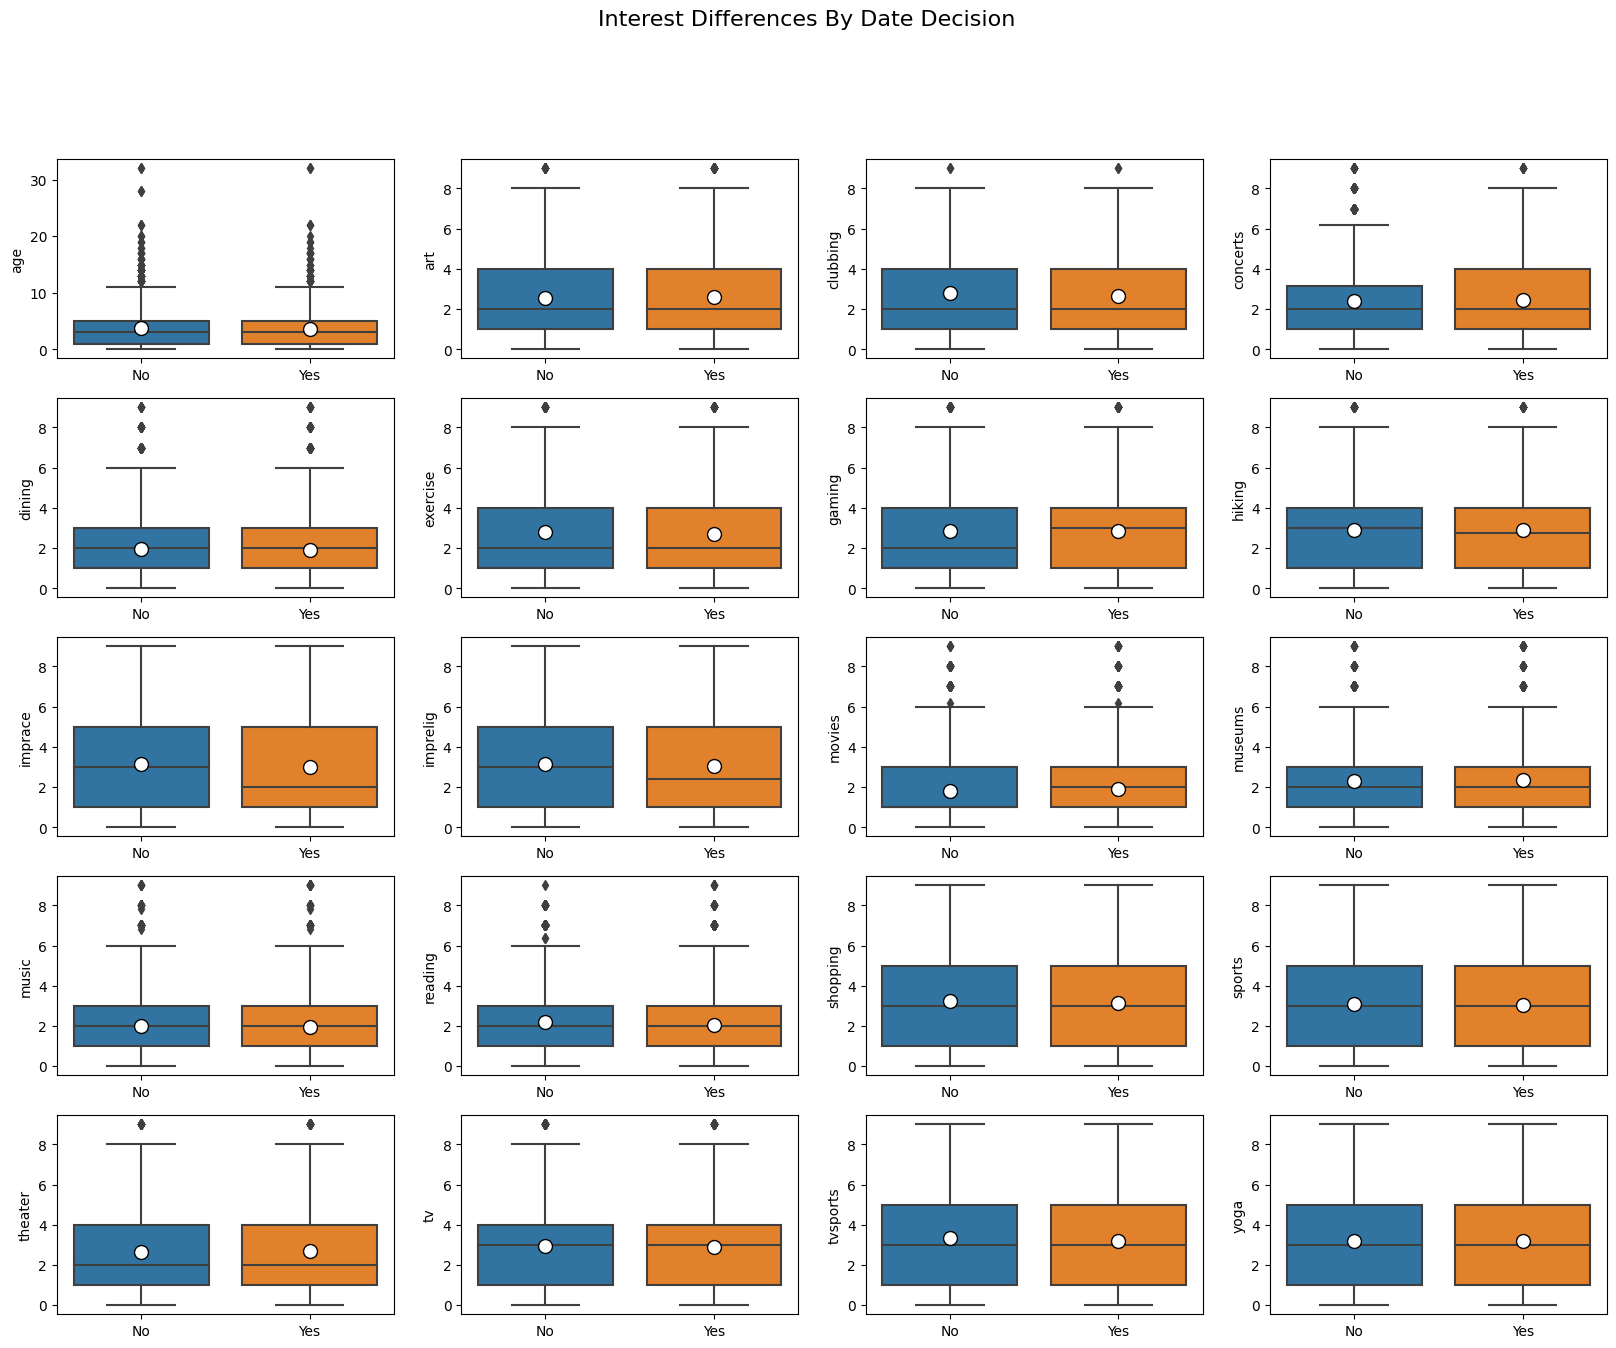

In [33]:
import warnings
warnings.filterwarnings("ignore")

d = list(df.columns[df.columns.str.endswith('_d')])
a = df[d+['dec']]
fig, axs = plt.subplots(5,4, figsize=(20,15))
axs = axs.ravel()
fig.suptitle('Interest Differences By Date Decision', fontsize=16)
for i in range(len(a.columns)-1):
    sns.boxplot(x=a['dec'], y=a.iloc[:,i], ax=axs[i], showmeans=True, meanprops={"marker":"o",
                    "markerfacecolor":"white", 
                    "markeredgecolor":"black",
                    "markersize":"10"})
    axs[i].set_xticklabels(["No", "Yes"])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel([x[:-2] for x in d][i])

plt.tight_layout
plt.savefig('Interest_Difference_by_Decision.png')
plt.show()

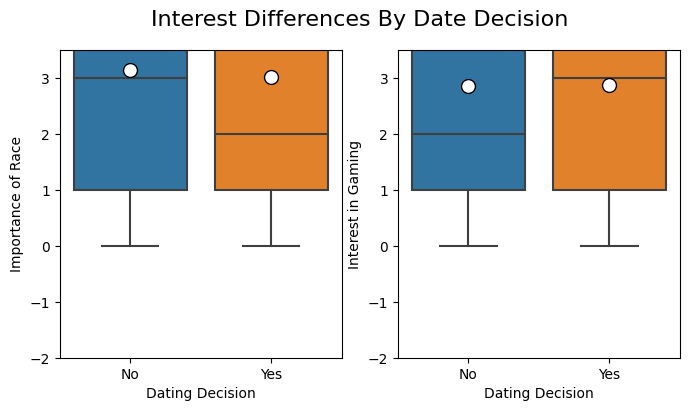

In [34]:
d = list(['imprace_d', 'gaming_d'])
a = df[d+['dec']]
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs = axs.ravel()
fig.suptitle('Interest Differences By Date Decision', fontsize=16)
axs
for i in range(len(a.columns)-1):
    sns.boxplot(x=a['dec'], y=a.iloc[:,i], ax=axs[i], showmeans=True, meanprops={"marker":"o",
                    "markerfacecolor":"white", 
                    "markeredgecolor":"black",
                    "markersize":"10"})
    axs[i].set_xticklabels(["No", "Yes"])
    axs[i].set_xlabel("Dating Decision")
    axs[i].set_ylabel([x[:-2] for x in d][i])

axs[0].set_ylabel('Importance of Race')
axs[1].set_ylabel('Interest in Gaming')
axs[0].set_ylim(-2, 3.5)
axs[1].set_ylim(-2, 3.5)
plt.tight_layout
plt.show()

In [35]:
# Correlation of our variables with our response

# categorical and numerical variables so far
cat_variables = ["gender", "field_cd", "race", "date_s", "goal_s", "race_s", "go_out_s", "field_cd_s"]
num_variables = list(df.columns.difference(cat_variables + ["dec"]))
num_variables.remove("iid")
num_variables.remove("pid")

In [36]:
correlations_with_response = df[num_variables + ["dec"]].corr()["dec"]
correlations_with_response[correlations_with_response < -0.2]
big_cor = correlations_with_response[(correlations_with_response > 0.2)  & (correlations_with_response < 1)].sort_values()

# remove weighted variables for visualization 
big_cor = big_cor[~big_cor.index.str.endswith("_weighted")]

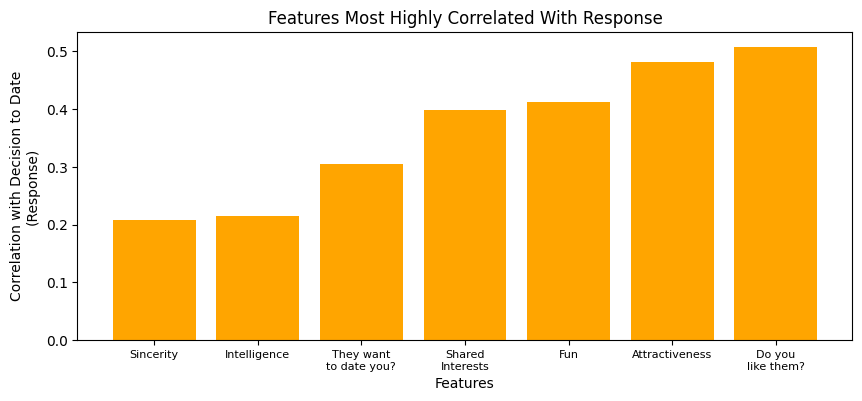

In [37]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4)) 
ax.bar(big_cor.index, big_cor , color='orange')
ax.set_xticklabels([f'Sincerity', f'Intelligence',f'They want\nto date you?', f'Shared\nInterests', 'Fun','Attractiveness',f'Do you\nlike them?'])
plt.xticks(fontsize=8, rotation=0)
ax.set_title('Features Most Highly Correlated With Response')
ax.set_ylabel(f'Correlation with Decision to Date\n(Response)')
ax.set_xlabel('Features');

In [38]:
big_cor

sinc     0.208781
intel    0.215075
prob     0.305879
shar     0.398920
fun      0.411574
attr     0.482134
like     0.508045
Name: dec, dtype: float64

# Final Data Cleaning & Transformation

In [39]:
df_original = df.copy()

#### Standardize Numerical Variables

In [40]:
scaler = StandardScaler() 
df[num_variables] = scaler.fit_transform(df[num_variables])

#### Variance Inflation Factor

In [41]:
# find highly correlated features using variance inflation factor
# for numerical variables
vif_data = pd.DataFrame()
vif_data["feature"] = df[num_variables].columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df[num_variables].values, i)
                          for i in range(len(df[num_variables].columns))]
vif_data.sort_values(by="VIF", ascending=False)

,feature,VIF
6,attr1_1,3.337124
20,like,3.128503
11,fun,2.412984
18,intel,2.398921
22,museums_d,2.160974
26,shar,2.156571
4,art_d,2.109288
29,sinc,1.982905
5,attr,1.944195
27,shar1_1,1.934285


#### One-Hot Encode Categorical Non-Binary Variables + Gender

In [42]:
ohe_variables = ["race", "gender", "field_cd"]
encoder = OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)
encoded_cat_df = pd.DataFrame(encoder.fit_transform(df[ohe_variables]), 
    columns=encoder.get_feature_names_out(),
    index=df.index)

df = pd.merge(df, encoded_cat_df, left_index=True, right_index=True).drop(columns=ohe_variables)

#### Splitting Data Into X and Y

In [45]:
# df.info()
X = df[df.columns.difference(["dec"])] 
y = df["dec"]

# remove iid and pid from X as it would bias our data 
X = X.drop(columns=["iid", "pid"])
X.shape # 50 features

(8368, 50)

# Baseline Model

### Splitting data

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [47]:
# Similar Proportion of response in y_train and y_test: we don't need to stratify
y_train.sum()/len(y_train), y_test.sum()/len(y_test) 

(0.4208246190618464, 0.4169653524492234)

### Logistic regression

In [48]:
results = []
def add_results(results, model, train_acc, test_acc, precision=0, threshold=0.5):
    results.append({'Model': model,
    'Train_Accuracy': round(train_acc, 4),
    'Test_Accuracy': round(test_acc, 4)})

In [49]:
logit = LogisticRegression(penalty="none", random_state=42)
logit.fit(X_train, y_train)

acc_train_logit = logit.score(X_train, y_train)
acc_test_logit = logit.score(X_test, y_test)

print(f"Train Accuracy: {round(acc_train_logit * 100, 2)}%")
print(f"Test Accuracy: {round(acc_test_logit * 100, 2)}%")

y_pred_test_proba = logit.predict_proba(X_test)[:, 1]
add_results(results, "Baseline", acc_train_logit, acc_test_logit)

Train Accuracy: 79.18%
Test Accuracy: 76.16%


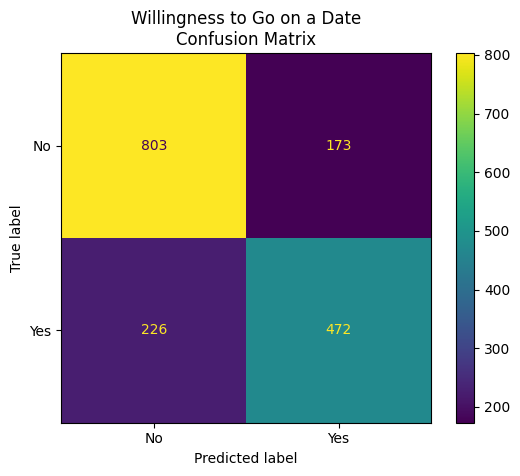

True Negative Rate: 82.27%
True Positive Rate: 67.62%
Precision: 73.18%
F1 Score: 70.29%


In [50]:
# confusion matrix
y_pred_test = logit.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
display.plot()
plt.title(f"Willingness to Go on a Date\nConfusion Matrix")
plt.show()

specificity = round((cm[0][0] / sum(cm[0, :])) * 100, 2)
sensitivity = round((cm[1][1] / sum(cm[1, :])) * 100, 2)
precision = round((cm[1][1] / sum(cm[:, 1])) * 100, 2)
f1_score = round(2 * (precision * sensitivity) / (precision + sensitivity), 2)

print(f"True Negative Rate: {specificity}%")
print(f"True Positive Rate: {sensitivity}%")
print(f"Precision: {precision}%")
print(f"F1 Score: {f1_score}%")

In [51]:
# feature importance
baseline_feat = pd.DataFrame(list(zip(logit.coef_.tolist()[0], X_train.columns)),
    columns=["Coeffient Value", "Feature"])
baseline_feat["Odds Change"] = np.exp(baseline_feat["Coeffient Value"])
baseline_feat.sort_values(by="Coeffient Value", ascending=False).head(8)

,Coeffient Value,Feature,Odds Change
30,1.001146,like,2.721399
5,0.857998,attr,2.358435
21,0.504804,gender_1,1.656661
34,0.386777,prob,1.472228
18,0.274315,fun,1.315629
41,0.239438,shar,1.270535
39,0.211706,race_s,1.235785
15,0.183674,field_cd_5,1.201624


In [52]:
# observations classified correctly and incorrectly
correct = df_original.loc[X_test[logit.predict(X_test) == y_test].index]
incorrect = df_original.loc[X_test[logit.predict(X_test) != y_test].index]

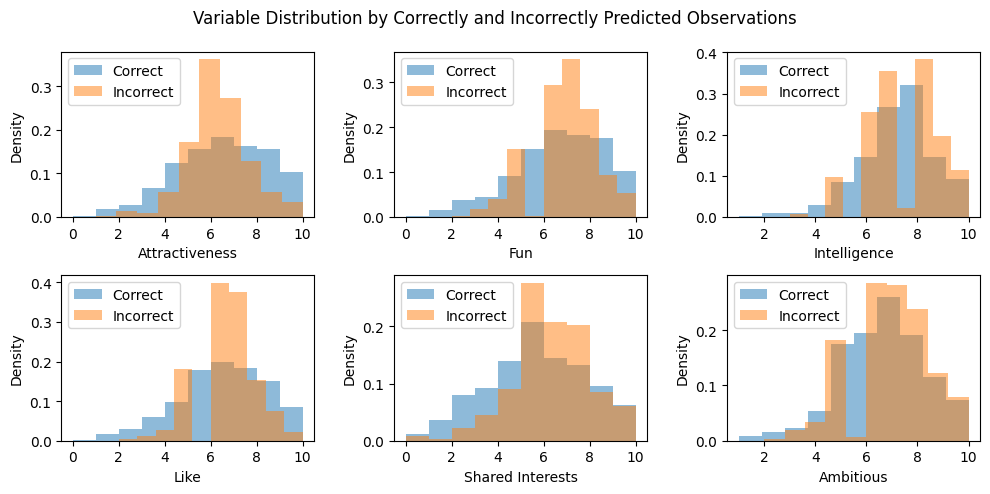

In [53]:
diff_variables_lr = ["attr", "fun", "intel", "like", "shar", "amb"]
diff_vars_lr_names = ["Attractiveness", "Fun", "Intelligence", "Like", "Shared Interests", "Ambitious"]

fig, axs = plt.subplots(2, 3, figsize=(10,5))
axs = axs.ravel()

for ax, var, var_name, in zip(axs, diff_variables_lr, diff_vars_lr_names):
    ax.hist(correct[var], alpha=0.5, density=True, label="Correct")
    ax.hist(incorrect[var], alpha=0.5, density=True, label="Incorrect")
    ax.set_xlabel(var_name)
    ax.set_ylabel("Density")
    ax.legend()

plt.suptitle("Variable Distribution by Correctly and Incorrectly Predicted Observations")
plt.tight_layout()
plt.show()

# Models 

### Logistic Lasso Regression

In [54]:
# logistic regression
# with cross-validation

parameters_lr = {'C': [0.01, 0.05, 0.1, 0.5],
                'random_state': [42],
                'solver': ['liblinear'],
                'penalty': ['l1']}

log_reg = LogisticRegression()
log_grid = GridSearchCV(log_reg, param_grid=parameters_lr, 
    scoring='accuracy', cv=5, verbose=False, n_jobs=-1, error_score='raise')
log_grid.fit(X_train, y_train)
print("Best parameters:")
print(log_grid.best_params_)

y_train_accuracy = log_grid.best_estimator_.score(X_train, y_train)
y_test_accuracy = log_grid.best_estimator_.score(X_test, y_test)

print(f"Train Accuracy: {round(y_train_accuracy * 100, 2)}%")
print(f"Test Accuracy: {round(y_test_accuracy * 100, 2)}%")

# cm = get_confusion_matrix(threshold, y_pred_test_proba, y_test, X_test)
add_results(results, "Logistic Regression", y_train_accuracy, y_test_accuracy)

{'C': 0.1, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
Train Accuracy: 79.24%
Test Accuracy: 76.7%


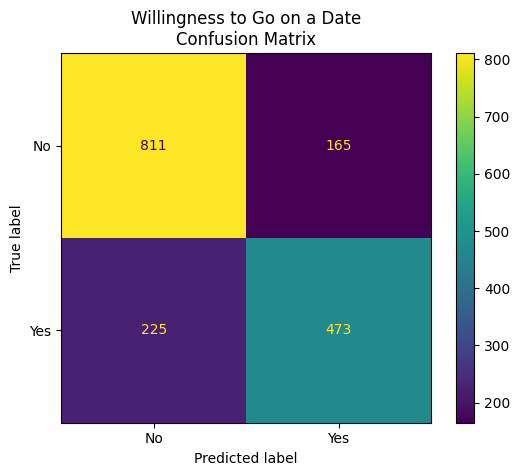

True Negative Rate: 83.09%
True Positive Rate: 67.77%
Precision: 74.14%
F1 Score: 70.81%


In [55]:
# confusion matrix
y_pred_test = log_grid.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
display.plot()
plt.title(f"Willingness to Go on a Date\nConfusion Matrix")
plt.show()

specificity = round((cm[0][0] / sum(cm[0, :])) * 100, 2)
sensitivity = round((cm[1][1] / sum(cm[1, :])) * 100, 2)
precision = round((cm[1][1] / sum(cm[:, 1])) * 100, 2)
f1_score = round(2 * (precision * sensitivity) / (precision + sensitivity), 2)

print(f"True Negative Rate: {specificity}%")
print(f"True Positive Rate: {sensitivity}%")
print(f"Precision: {precision}%")
print(f"F1 Score: {f1_score}%")

#### Logistic Regression with Regularization Feature Importance

In [56]:
pred_coeff = {}

for name, value in zip(X.columns,log_grid.best_estimator_.coef_.tolist()[0]):
    pred_coeff[name] = value

predictors_important = [pred for pred, coef in pred_coeff.items() if coef != 0]
predictors_not_important = [pred for pred, coef in pred_coeff.items() if coef == 0]

print(f'The number of predictors that were deemed important is {len(predictors_important)}')
print(f'The number of predictors that were deemed as unimportant is {len(predictors_not_important)}')

The number of predictors that were deemed important is 40
The number of predictors that were deemed as unimportant is 10


In [57]:
print(f'Unimportant Predictors: {predictors_not_important}')

Unimportant Predictors: ['field_cd_2', 'field_cd_3', 'field_cd_5', 'field_cd_6', 'go_out_s', 'imprace_d', 'intel', 'race_3.0', 'theater_d', 'yoga_d']


In [58]:
# attributes with largest positive coefficients:
# like, attr, gender_1, prob, fun
lr_feat = pd.DataFrame(list(zip(log_grid.best_estimator_.coef_.tolist()[0], X_train.columns)),
    columns=["Coeffient Value", "Feature"])
lr_feat["Odds Change"] = np.exp(lr_feat["Coeffient Value"])
lr_feat.sort_values(by="Coeffient Value", ascending=False).head(8)

,Coeffient Value,Feature,Odds Change
30,0.971686,like,2.642395
5,0.837653,attr,2.310938
21,0.378982,gender_1,1.460797
34,0.365005,prob,1.440521
18,0.248011,fun,1.281474
41,0.224565,shar,1.251778
37,0.155814,race_4.0,1.168608
39,0.135681,race_s,1.145317


### kNN

In [59]:
parameters_knn = {'n_neighbors': range(5, 31),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]}

knn = KNeighborsClassifier()
  
knn_grid = GridSearchCV(knn, param_grid=parameters_knn, scoring='accuracy', 
    return_train_score=False, verbose=False)
knn_grid.fit(X_train, y_train)
print("Best parameters:")
print(knn_grid.best_params_)

y_train_accuracy = knn_grid.best_estimator_.score(X_train, y_train)
y_test_accuracy = knn_grid.best_estimator_.score(X_test, y_test)
y_pred_test_proba = knn_grid.predict_proba(X_test)[:,1]
y_pred_train_proba = knn_grid.predict_proba(X_train)[:, 1]

print(f"Train Accuracy: {round(y_train_accuracy * 100, 2)}%")
print(f"Test Accuracy: {round(y_test_accuracy * 100, 2)}%")

# cm = get_confusion_matrix(0.5, y_pred_test_proba, y_test, X_test)
add_results(results, "KNN", y_train_accuracy, y_test_accuracy)


{'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
Train Accuracy: 100.0%
Test Accuracy: 77.42%


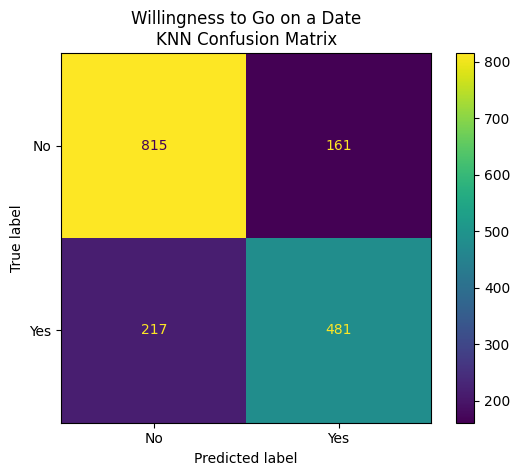

True Negative Rate: 83.5%
True Positive Rate: 68.91%
Precision: 74.92%
F1 Score: 71.79%


In [60]:
# confusion matrix
y_pred_test = knn_grid.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
display.plot()
plt.title(f"Willingness to Go on a Date\nConfusion Matrix")
plt.show()

specificity = round((cm[0][0] / sum(cm[0, :])) * 100, 2)
sensitivity = round((cm[1][1] / sum(cm[1, :])) * 100, 2)
precision = round((cm[1][1] / sum(cm[:, 1])) * 100, 2)
f1_score = round(2 * (precision * sensitivity) / (precision + sensitivity), 2)

print(f"True Negative Rate: {specificity}%")
print(f"True Positive Rate: {sensitivity}%")
print(f"Precision: {precision}%")
print(f"F1 Score: {f1_score}%")

### Decision Tree

In [61]:
# with cross-validation
hparameters_dt = {'splitter': ['best', 'random'],
                'max_depth' : [8,10,12],
                'random_state': [42]}

dec_tree = DecisionTreeClassifier()
dt_grid = GridSearchCV(dec_tree, param_grid=hparameters_dt, scoring='accuracy', 
    cv=5, verbose=False, n_jobs=-1)
dt_grid.fit(X_train, y_train)
print("Best parameters:")
print(dt_grid.best_params_)

y_train_accuracy = dt_grid.best_estimator_.score(X_train, y_train)
y_test_accuracy = dt_grid.best_estimator_.score(X_test, y_test)
y_pred_test_proba = dt_grid.predict_proba(X_test)[:,1]
y_pred_train_proba = dt_grid.predict_proba(X_train)[:, 1]

print(f"Train Accuracy: {round(y_train_accuracy * 100, 2)}%")
print(f"Test Accuracy: {round(y_test_accuracy * 100, 2)}%")

# cm = get_confusion_matrix(0.5, y_pred_test_proba, y_test, X_test)
add_results(results, "Decision Tree", y_train_accuracy, y_test_accuracy)

{'max_depth': 8, 'random_state': 42, 'splitter': 'best'}
Train Accuracy: 85.36%
Test Accuracy: 77.0%


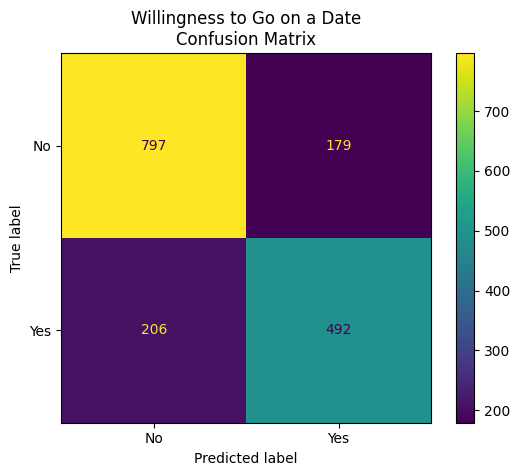

True Negative Rate: 81.66%
True Positive Rate: 70.49%
Precision: 73.32%
F1 Score: 71.88%


In [62]:
# confusion matrix
y_pred_test = dt_grid.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
display.plot()
plt.title(f"Willingness to Go on a Date\nConfusion Matrix")
plt.show()

specificity = round((cm[0][0] / sum(cm[0, :])) * 100, 2)
sensitivity = round((cm[1][1] / sum(cm[1, :])) * 100, 2)
precision = round((cm[1][1] / sum(cm[:, 1])) * 100, 2)
f1_score = round(2 * (precision * sensitivity) / (precision + sensitivity), 2)

print(f"True Negative Rate: {specificity}%")
print(f"True Positive Rate: {sensitivity}%")
print(f"Precision: {precision}%")
print(f"F1 Score: {f1_score}%")

In [63]:
# feature importance
dt_feat = pd.DataFrame(list(zip(X_train.columns, dt_grid.best_estimator_.feature_importances_)), 
    columns=["Feature", "Importance"])
dt_feat.sort_values(by="Importance", ascending=False).head(8)

,Feature,Importance
30,like,0.495353
5,attr,0.121643
34,prob,0.032310
42,shar1_1,0.032168
19,fun1_1,0.030556
18,fun,0.024597
0,age,0.023998
3,amb1_1,0.021270


[Text(0.5, 0.875, 'like <= 0.092\ngini = 0.487\nsamples = 6694\nvalue = [3877, 2817]\nclass = No'),
 Text(0.25, 0.625, 'like <= -0.458\ngini = 0.325\nsamples = 3692\nvalue = [2937, 755]\nclass = No'),
 Text(0.125, 0.375, 'attr <= -0.877\ngini = 0.196\nsamples = 2155\nvalue = [1918, 237]\nclass = No'),
 Text(0.0625, 0.125, 'gini = 0.072\nsamples = 886\nvalue = [853, 33]\nclass = No'),
 Text(0.1875, 0.125, 'gini = 0.27\nsamples = 1269\nvalue = [1065, 204]\nclass = No'),
 Text(0.375, 0.375, 'attr <= 0.08\ngini = 0.447\nsamples = 1537\nvalue = [1019, 518]\nclass = No'),
 Text(0.3125, 0.125, 'gini = 0.387\nsamples = 1059\nvalue = [781, 278]\nclass = No'),
 Text(0.4375, 0.125, 'gini = 0.5\nsamples = 478\nvalue = [238, 240]\nclass = Yes'),
 Text(0.75, 0.625, 'attr <= -0.047\ngini = 0.43\nsamples = 3002\nvalue = [940, 2062]\nclass = Yes'),
 Text(0.625, 0.375, 'prob <= -0.196\ngini = 0.492\nsamples = 775\nvalue = [438, 337]\nclass = No'),
 Text(0.5625, 0.125, 'gini = 0.377\nsamples = 163\nvalue

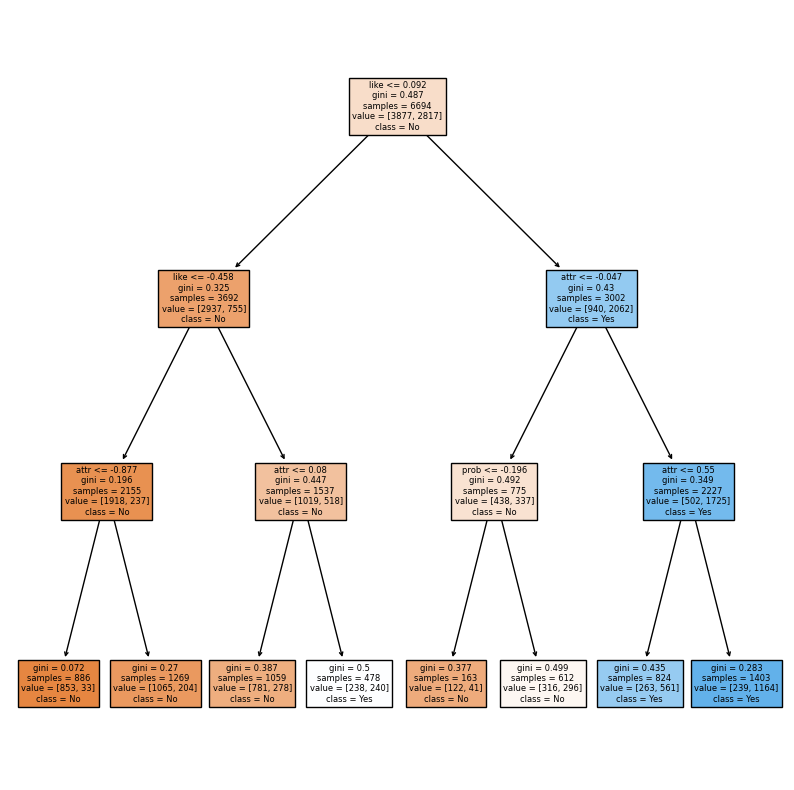

In [64]:
# visualize "shorter" version of decision tree
dt_best_short = DecisionTreeClassifier(max_depth=3, splitter="best")
dt_best_short.fit(X_train, y_train)

fig = plt.figure(figsize=(10,10))
tree.plot_tree(dt_best_short, 
              feature_names=X_train.columns,  
                class_names=["No", "Yes"],
                filled=True)

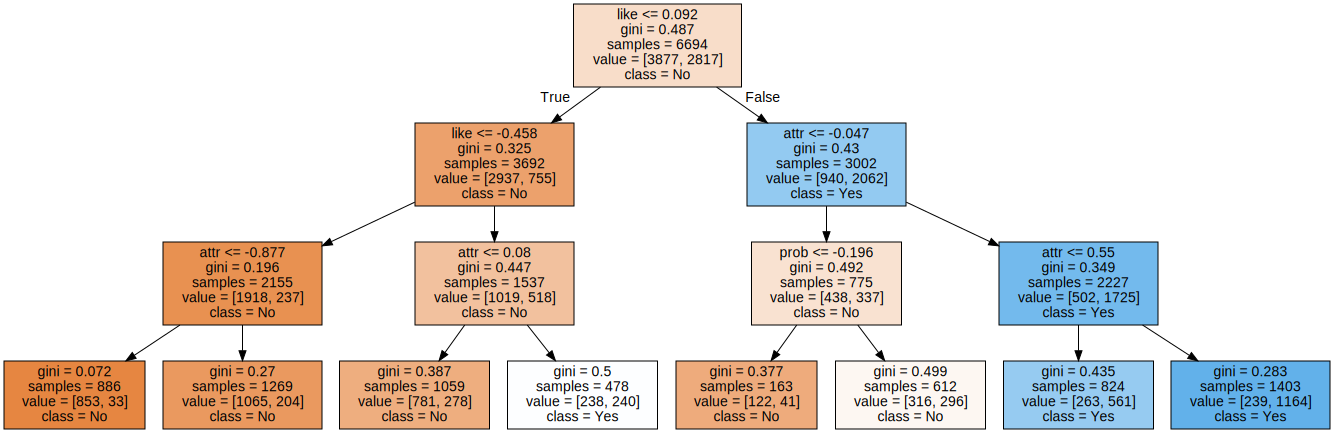

In [65]:
# another style of visualization
graph_data = tree.export_graphviz(dt_best_short,
    feature_names=X_train.columns,
    class_names=["No", "Yes"],
    filled=True)

graph = graphviz.Source(graph_data)
display_svg(graph)

### Random Forest

In [66]:
hparameters_rf = {'n_estimators' : [100,400,600],
    'max_depth': [15,20,25],
    'random_state': [42]}

rd_fort = RandomForestClassifier()
rf_grid = GridSearchCV(rd_fort, param_grid=hparameters_rf, 
        scoring='accuracy', cv=5, verbose=False, n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("Best parameters:")
print(rf_grid.best_params_)

y_train_accuracy = rf_grid.best_estimator_.score(X_train, y_train)
y_test_accuracy = rf_grid.best_estimator_.score(X_test, y_test)
y_pred_test_proba = rf_grid.predict_proba(X_test)[:,1]
y_pred_train_proba = rf_grid.predict_proba(X_train)[:, 1]

print(f"Train Accuracy: {round(y_train_accuracy * 100, 2)}%")
print(f"Test Accuracy: {round(y_test_accuracy * 100, 2)}%")

# cm = get_confusion_matrix(0.5, y_pred_test_proba, y_test, X_test)
add_results(results, "Random Forest", y_train_accuracy, y_test_accuracy)

{'max_depth': 20, 'n_estimators': 600, 'random_state': 42}
Train Accuracy: 100.0%
Test Accuracy: 79.57%


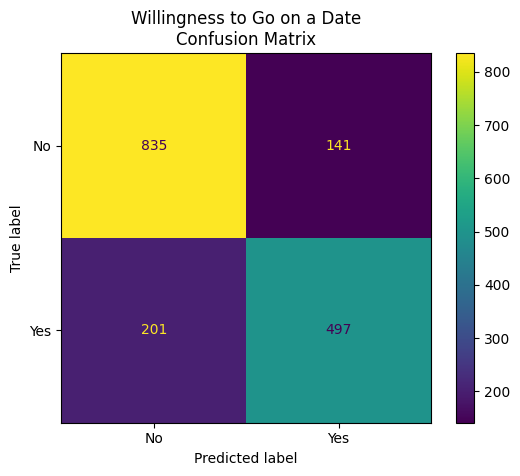

True Negative Rate: 85.55%
True Positive Rate: 71.2%
Precision: 77.9%
F1 Score: 74.4%


In [68]:
# confusion matrix
y_pred_test = rf_grid.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
display.plot()
plt.title(f"Willingness to Go on a Date\nConfusion Matrix")
plt.show()

specificity = round((cm[0][0] / sum(cm[0, :])) * 100, 2)
sensitivity = round((cm[1][1] / sum(cm[1, :])) * 100, 2)
precision = round((cm[1][1] / sum(cm[:, 1])) * 100, 2)
f1_score = round(2 * (precision * sensitivity) / (precision + sensitivity), 2)

print(f"True Negative Rate: {specificity}%")
print(f"True Positive Rate: {sensitivity}%")
print(f"Precision: {precision}%")
print(f"F1 Score: {f1_score}%")

In [67]:
# feature imporance
rf_feat = pd.DataFrame(list(zip(X_train.columns, rf_grid.best_estimator_.feature_importances_)), 
    columns=["Feature", "Importance"])
rf_feat.sort_values(by="Importance", ascending=False).head(8)

,Feature,Importance
30,like,0.119848
5,attr,0.113953
41,shar,0.056223
18,fun,0.052217
34,prob,0.040834
6,attr1_1,0.026338
42,shar1_1,0.025800
29,intel1_1,0.024951


### 

## XGBoost

In [69]:
hparameters_xgb = {'nthread' : [4],
                 'objective' : ['binary:logistic'],
                 'learning_rate' : [0.06, 0.08, 0.10], 
                 'max_depth' : [6, 8, 10],
                 'subsample' : [0.8],
                 'colsample_bytree' : [0.7],
                 'n_estimators' : [100, 250, 500],
                 'random_state' : [42]}

X_train_xgb = X_train 
X_test_xgb = X_test

xgb_class = XGBClassifier()
xgb_grid = GridSearchCV(xgb_class, param_grid=hparameters_xgb, 
    scoring='accuracy', cv=5, verbose=False, n_jobs=-1, error_score='raise')
xgb_grid.fit(X_train_xgb, y_train)
print("Best parameters:")
print(xgb_grid.best_params_)

y_train_accuracy = xgb_grid.best_estimator_.score(X_train_xgb, y_train)
y_test_accuracy = xgb_grid.best_estimator_.score(X_test_xgb, y_test)
y_pred_test_proba = xgb_grid.predict_proba(X_test_xgb)[:,1]
y_pred_train_proba = xgb_grid.predict_proba(X_train_xgb)[:, 1]

print(f"Train Accuracy: {round(y_train_accuracy * 100, 2)}%")
print(f"Test Accuracy: {round(y_test_accuracy * 100, 2)}%")
add_results(results, "XGB", y_train_accuracy, y_test_accuracy)

{'colsample_bytree': 0.7, 'learning_rate': 0.06, 'max_depth': 8, 'n_estimators': 500, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 42, 'subsample': 0.8}
Train Accuracy: 100.0%
Test Accuracy: 82.02%


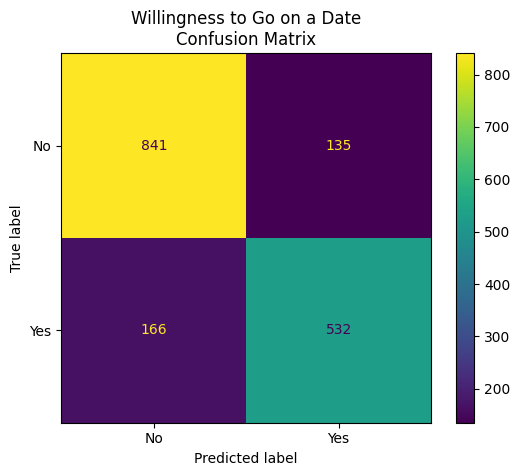

True Negative Rate: 86.17%
True Positive Rate: 76.22%
Precision: 79.76%
F1 Score: 77.95%


In [70]:
# confusion matrix
y_pred_test = xgb_grid.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
display.plot()
plt.title(f"Willingness to Go on a Date\nConfusion Matrix")
plt.show()

specificity = round((cm[0][0] / sum(cm[0, :])) * 100, 2)
sensitivity = round((cm[1][1] / sum(cm[1, :])) * 100, 2)
precision = round((cm[1][1] / sum(cm[:, 1])) * 100, 2)
f1_score = round(2 * (precision * sensitivity) / (precision + sensitivity), 2)

print(f"True Negative Rate: {specificity}%")
print(f"True Positive Rate: {sensitivity}%")
print(f"Precision: {precision}%")
print(f"F1 Score: {f1_score}%")

In [71]:
# feature importance
xgb_feat = pd.DataFrame(list(zip(X_train.columns, xgb_grid.best_estimator_.feature_importances_)), 
    columns=["Feature", "Importance"])
xgb_feat.sort_values(by="Importance", ascending=False).head(8)

,Feature,Importance
30,like,0.138702
5,attr,0.074270
18,fun,0.033959
34,prob,0.024979
35,race_2.0,0.024646
21,gender_1,0.024041
41,shar,0.023783
37,race_4.0,0.022826


## Stacking

In [72]:
estimators = [
     ("lr", LogisticRegression(C=0.1, penalty="l1", solver="liblinear", random_state=42)),
     ("knn", KNeighborsClassifier(n_neighbors=30, p=1, weights="distance")),
     ("dt", DecisionTreeClassifier(max_depth=8, splitter="best")),
     ("rf", RandomForestClassifier(max_depth=20, n_estimators=600, random_state=42)),
     ("xgb", XGBClassifier(learning_rate=0.08, max_depth=10, n_estimators=500))]

stacking = StackingClassifier(estimators=estimators, 
    final_estimator=LogisticRegression())
stacking.fit(X_train, y_train).score(X_test, y_test)
acc_train_stacking = stacking.score(X_train, y_train)
acc_test_stacking = stacking.score(X_test, y_test)

print(f"Train Accuracy: {round(acc_train_stacking * 100, 2)}%")
print(f"Test Accuracy: {round(acc_test_stacking * 100, 2)}%")
add_results(results, "Stacking", acc_train_stacking, acc_test_stacking)

Train Accuracy: 100.0%
Test Accuracy: 81.96%


## Summary

In [73]:
df_results = pd.DataFrame(results)
df_results

,Model,Train_Accuracy,Test_Accuracy
0,Baseline,0.7918,0.7616
1,Logistic Regression,0.7924,0.7670
2,KNN,1.0000,0.7742
3,Decision Tree,0.8536,0.7700
4,Random Forest,1.0000,0.7957
5,XGB,1.0000,0.8202
6,Stacking,1.0000,0.8196


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=423f9694-7ed9-49da-9695-a21b92f5bad4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>